# Potato Disease Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import zipfile
zip_file_path = '/content/drive/MyDrive/potato dataset.zip'
extract_path = '/content/extracted/'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

### Import all the Dependencies

In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Set all the Constants

In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/extracted/PLD_3_Classes_256/Training",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3251 files belonging to 3 classes.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/extracted/PLD_3_Classes_256/Validation",
    seed=123,
    shuffle=False,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 416 files belonging to 3 classes.


In [13]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/extracted/PLD_3_Classes_256/Testing",
    seed=123,
    shuffle=False,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 405 files belonging to 3 classes.


In [15]:
class_names = train_ds.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

In [16]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 2 0 2 0 2 0 2 2 0 2 1 0 0 2 1 1 1 0 0 1 2 2 1 0 1 0 2 0 2]


### Visualize some of the images from our dataset

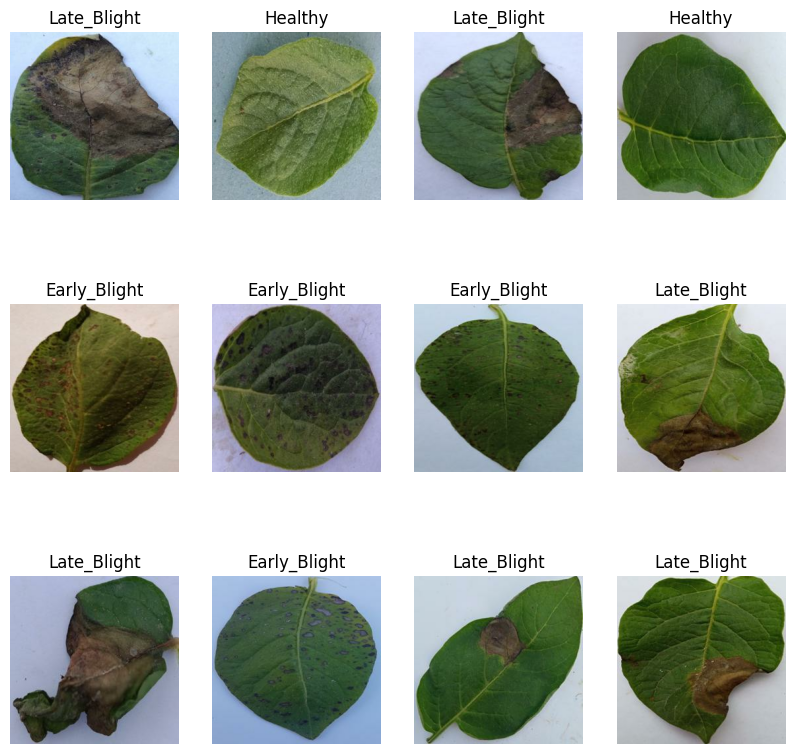

In [17]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

## Building the Model

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "potato.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[es, ckpt, rlp],
)

Epoch 1/50
102/102 [==============================] - ETA: 0s - loss: 1.0028 - accuracy: 0.4700
Epoch 1: loss improved from inf to 1.00277, saving model to potato.h5
102/102 [==============================] - 46s 333ms/step - loss: 1.0028 - accuracy: 0.4700 - val_loss: 0.9776 - val_accuracy: 0.5553 - lr: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


102/102 [==============================] - ETA: 0s - loss: 0.8908 - accuracy: 0.5884
Epoch 2: loss improved from 1.00277 to 0.89081, saving model to potato.h5
102/102 [==============================] - 34s 327ms/step - loss: 0.8908 - accuracy: 0.5884 - val_loss: 0.8907 - val_accuracy: 0.5986 - lr: 0.0010
Epoch 3/50
102/102 [==============================] - ETA: 0s - loss: 0.8336 - accuracy: 0.6370
Epoch 3: loss improved from 0.89081 to 0.83358, saving model to potato.h5
102/102 [==============================] - 33s 321ms/step - loss: 0.8336 - accuracy: 0.6370 - val_loss: 0.8214 - val_accuracy: 0.6418 - lr: 0.0010
Epoch 4/50
102/102 [==============================] - ETA: 0s - loss: 0.7642 - accuracy: 0.6909
Epoch 4: loss improved from 0.83358 to 0.76424, saving model to potato.h5
102/102 [==============================] - 33s 321ms/step - loss: 0.7642 - accuracy: 0.6909 - val_loss: 0.6862 - val_accuracy: 0.7332 - lr: 0.0010
Epoch 5/50
102/102 [==============================] - ETA: 0

In [28]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 1s 73ms/step - loss: 0.0706 - accuracy: 0.9802


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [29]:
scores

[0.07064031809568405, 0.980246901512146]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 102}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

42

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0027666091918945,
 0.8908059597015381,
 0.8335794806480408,
 0.7642372250556946,
 0.4812280833721161]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

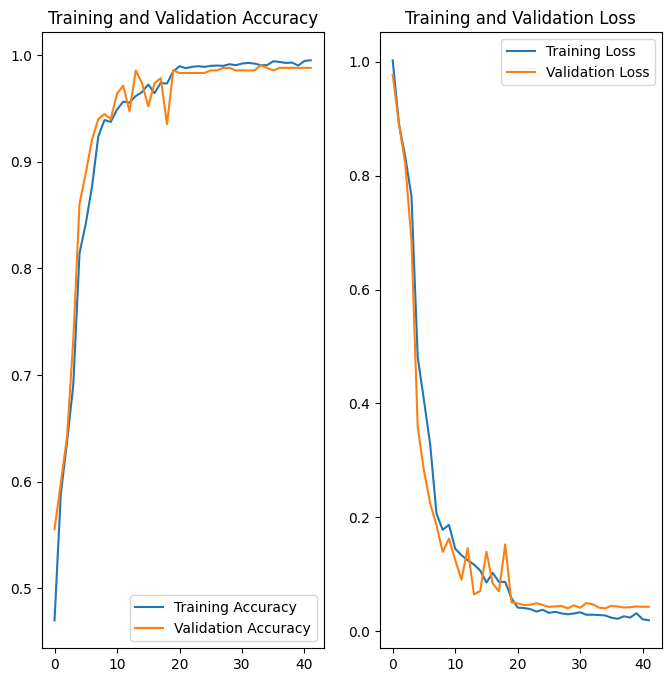

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(42), acc, label='Training Accuracy')
plt.plot(range(42), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(42), loss, label='Training Loss')
plt.plot(range(42), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Early_Blight
1/1 [==============================] - 0s 141ms/step
predicted label: Early_Blight


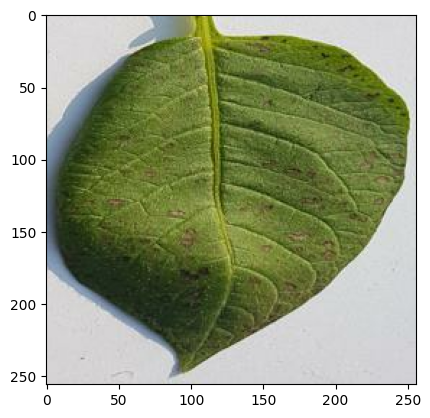

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 16ms/step


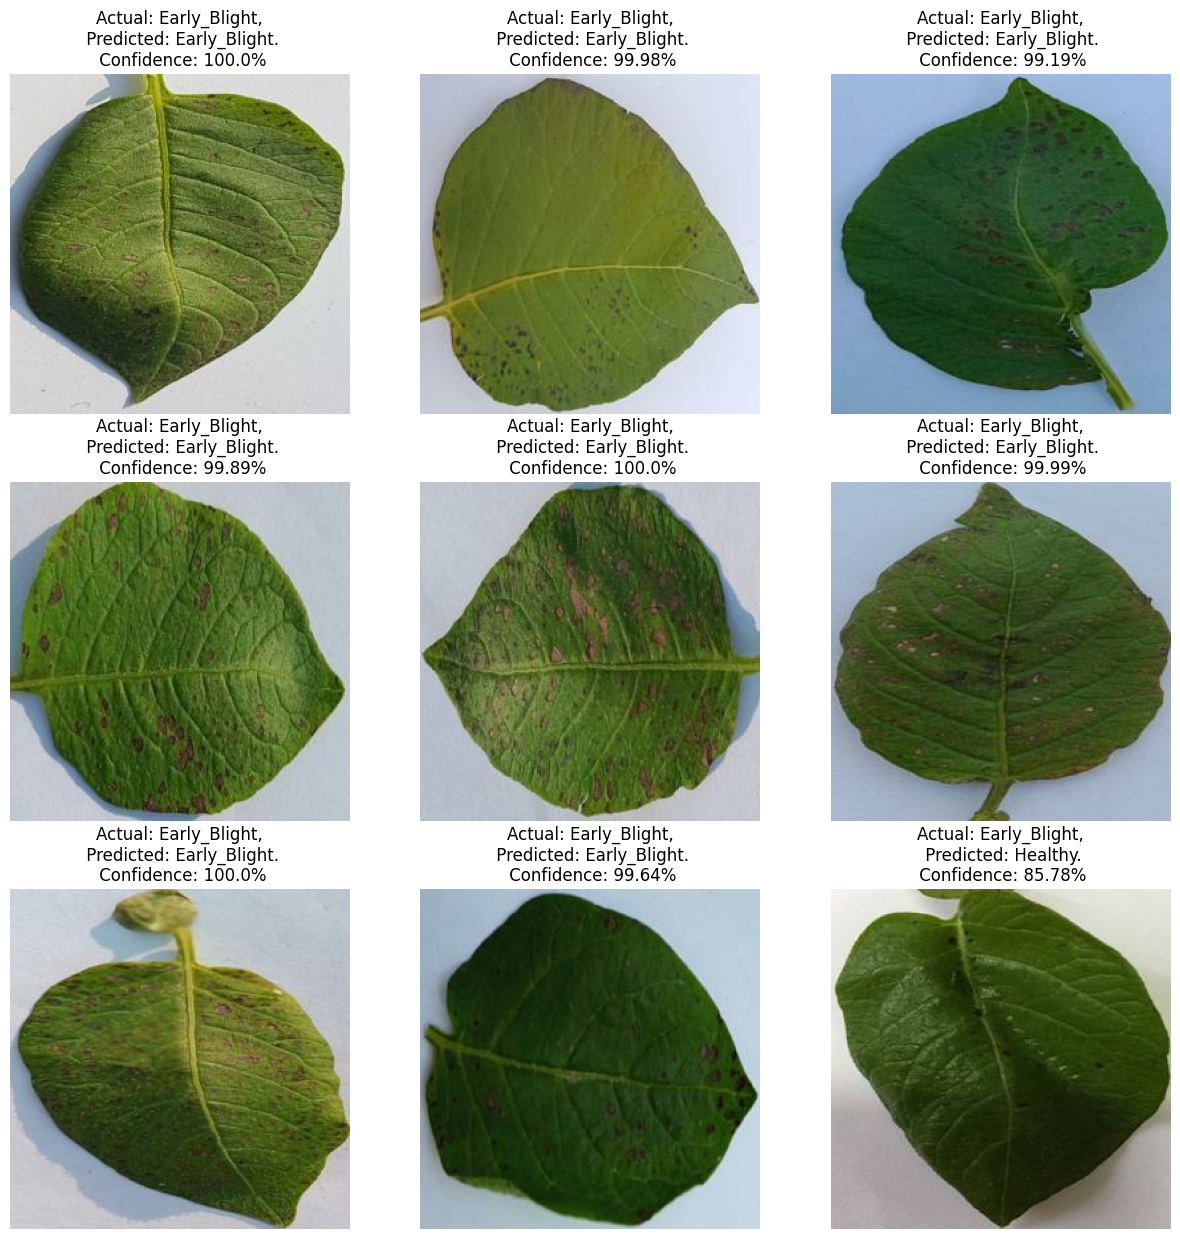

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")